In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
REBUILD_DATA = False

class DogsVsCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
#                     print(str(e))
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(f'Cats: {self.catcount}')
        print(f'Dogs: {self.dogcount}')
        
if REBUILD_DATA:
    dogs_vs_cats = DogsVsCats()
    dogs_vs_cats.make_training_data()    

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)

Text(0.5, 1.0, '[0. 1.]')

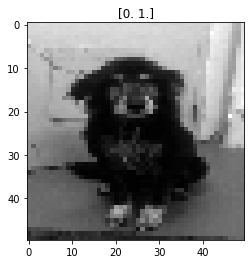

In [4]:
plt.imshow(training_data[10][0], cmap='gray')
plt.title(f'{training_data[10][1]}')

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('running on the GPU')
else:
    device = torch.device('cpu')
    print('running on the CPU')

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
#         print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
        
net = Net().to(device)

running on the GPU


In [6]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [7]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [8]:
# BATCH_SIZE = 32
# EPOCHS = 3

# def train(net):
#     optimizer = optim.Adam(net.parameters(), lr=0.001)
#     loss_function = nn.MSELoss()
#     for epoch in range(EPOCHS):
#         for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
#             batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
#             batch_y = train_y[i:i+BATCH_SIZE].to(device)
#             optimizer.zero_grad()
#             outputs = net(batch_X)
#             loss = loss_function(outputs, batch_y)
#             loss.backward()
#             optimizer.step()
            
#         print(f'Epoch: {epoch}. Loss: {loss}')
        
# def test(net):
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for i in tqdm(range(len(test_X))):
#             ground_truth = torch.argmax(test_y[i]).to(device)
#             net_output = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
#             predict = torch.argmax(net_output)

#             if predict == ground_truth:
#                 correct += 1
#             total += 1

#     print(f'Accuracy: {round(correct/total*100, 4)}%')

In [9]:
# train(net)
# test(net)

In [10]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [11]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    accuracy = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    
    return accuracy, loss

In [12]:
def test(size=32):
    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_accuracy, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    
    return val_accuracy, val_loss

In [13]:
val_accuracy, val_loss = test()
print(val_accuracy, val_loss)

0.53125 tensor(0.2499, device='cuda:0')


In [14]:
import time

In [15]:
MODEL_NAME = f'model-{int(time.time())}'

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 100
    EPOCHS = 5
    with open('model.log', 'a') as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f'{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},{round(float(val_acc), 2)},{round(float(val_loss), 4)}\n')
                    
train()       

  0%|          | 0/225 [00:00<?, ?it/s]

model-1595495926


100%|██████████| 225/225 [00:49<00:00,  4.53it/s]
